# Rice Yield Prediction: LightGBM with Optuna Tuning

## Overview
This notebook trains a **Gradient Boosting Machine (LightGBM)** to predict Rice yields. 

## Methodology
1.  **Feature Analysis:** Displaying used features.
2.  **Time-Series Split (Consistency Check):**
    * **Train (< 2016):** Model learning.
    * **Validation (2016 - 2020):** Hyperparameter tuning and early stopping.
    * **Test (>= 2020):** Final unseen evaluation.
3.  **Baseline:** Naive approach (Last Year's Yield).
4.  **Initial Model & Diagnostics:** Training a default LightGBM and plotting the **Learning Curve** to check for under/overfitting.
5.  **Optimization:** Using **Optuna** to find the best hyperparameters, visualized with parallel coordinates and importance plots.
6.  **Final Evaluation:** Comparing RMSE and R2 across all stages.

In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Loading

In [26]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# Define Target
TARGET_COL = 'Y_rice'
LAG_1_FEATURE = 'avg_yield_rice_1y'

# Clean Missing Targets
df_model = df.dropna(subset=[TARGET_COL])

print("Data Loaded Successfully.")

Data Loaded Successfully.


### 2. Feature Selection & Data Split
We display the features being used and split the data strictly by year to prevent leakage.

In [27]:
# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT contain "rice"
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and "rice" not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['year', 'area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2016)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2016 and < 2020)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2020)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})    : {len(X_train)}")
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")


Total Features Used: 27
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Feature Name,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,avg_rain_winter,avg_rain_spring,avg_rain_summer,avg_rain_autumn,avg_rain_annual,avg_solar_winter,avg_solar_spring,...,avg_temp_annual,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude



Training Samples   (<2014)    : 3472
Validation Samples (2014-2019): 575
Testing Samples    (>=2019)    : 575


### 3. Baseline Model
Calculating performance if we simply predicted "Last Year's Yield".

In [28]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 533.44


### 4. Initial Model & Learning Curve Analysis
We train a model with default parameters and visualize the **Learning Curve** to ensure the model is converging and check for early signs of overfitting.

Training until validation scores don't improve for 50 rounds
[100]	Train's rmse: 366.042	Train's l2: 133987	Validation's rmse: 517.049	Validation's l2: 267340
Early stopping, best iteration is:
[105]	Train's rmse: 360.46	Train's l2: 129932	Validation's rmse: 516.528	Validation's l2: 266801


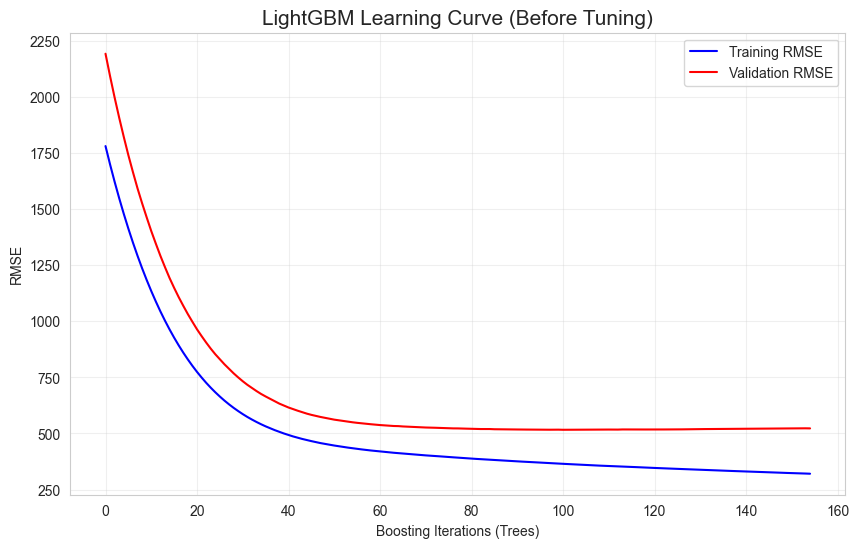

Initial Model Test RMSE: 526.13


In [29]:
# --- INITIAL MODEL TRAINING ---

# 1. Initialize LightGBM
model_init = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# 2. Dictionary to store training metrics for plotting
evals_result = {}

# 3. Train on TRAIN, Early Stop on VALIDATION
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_names=['Train', 'Validation'],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

# --- PLOT LEARNING CURVE (RMSE over Iterations) ---
def plot_learning_curve(evals_result, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = evals_result['Train'][metric]
    val_metric = evals_result['Validation'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title('LightGBM Learning Curve (Before Tuning)', fontsize=15)
    plt.xlabel('Boosting Iterations (Trees)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(evals_result)

# Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"Initial Model Test RMSE: {rmse_init_test:.2f}")

### 5. Optuna Hyperparameter Optimization
We optimize hyperparameters to minimize RMSE on the Validation set.

In [30]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.6),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study = optuna.create_study(direction='minimize', study_name='Rice_Yield_LGBM')
study.optimize(objective, n_trials=30)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-27 01:10:55,673] A new study created in memory with name: Rice_Yield_LGBM
[I 2025-11-27 01:10:56,075] Trial 0 finished with value: 538.3655372110373 and parameters: {'learning_rate': 0.06843406527123476, 'num_leaves': 49, 'max_depth': 6, 'min_child_samples': 46, 'subsample': 0.6795769875538558, 'colsample_bytree': 0.4420388213661552, 'reg_alpha': 0.054900591245470434, 'reg_lambda': 0.08665106989667373}. Best is trial 0 with value: 538.3655372110373.
[I 2025-11-27 01:10:56,399] Trial 1 finished with value: 536.4381094173823 and parameters: {'learning_rate': 0.06251372016528295, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8660509304595704, 'colsample_bytree': 0.3152485529135552, 'reg_alpha': 2.931098373919224e-08, 'reg_lambda': 3.146463907318455e-05}. Best is trial 1 with value: 536.4381094173823.
[I 2025-11-27 01:10:56,970] Trial 2 finished with value: 540.4720122103038 and parameters: {'learning_rate': 0.06581977134276465, 'num_leaves': 94, 'max


Best Parameters found:
{'learning_rate': 0.07064451988051876, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.7258579092297683, 'colsample_bytree': 0.5197390242575601, 'reg_alpha': 0.05753761512365869, 'reg_lambda': 0.016174303331823965}


### 6. Optuna Visualization
Visualizing the tuning process to understand parameter importance and convergence.

In [31]:
# --- OPTUNA VISUALIZATIONS ---
name = "Rice_Yield_Model"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
# fig.write_image(f'optuna_{name}_history.png') # Optional save
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
# fig.write_image(f'optuna_{name}_parallel_coordinate.png')
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
# fig.write_image(f'optuna_{name}_slice.png')
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    # fig.write_image(f'optuna_{name}_param_importance.png')
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Tuned Model Training
Retraining the model using the best parameters found on the full history (Train + Validation).

In [32]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 2. Initialize with Best Params
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = lgb.LGBMRegressor(**best_params)

# 3. Train on Full History
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	training's rmse: 427.395	training's l2: 182666	valid_1's rmse: 505.124	valid_1's l2: 255150


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=533.44, R2=0.9427
Initial Model:  RMSE=526.13, R2=0.9443
Tuned Model:    RMSE=505.12, R2=0.9487 (RMSE Improved 5.31%)


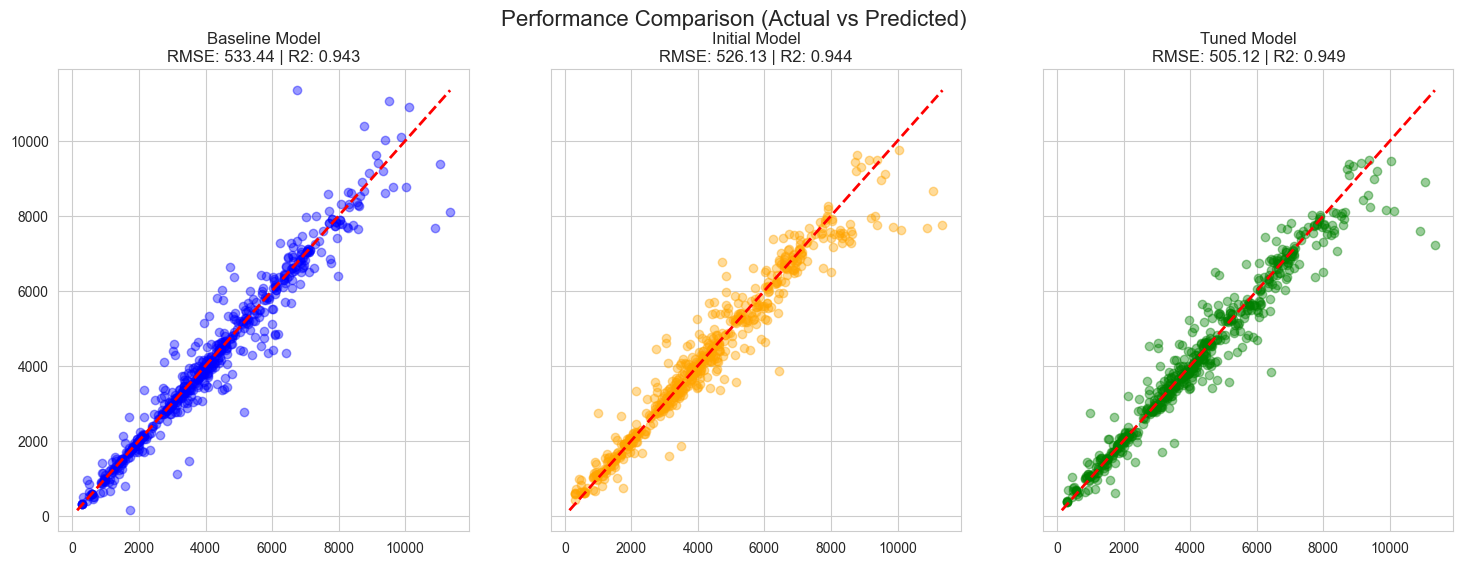

In [33]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle('Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.show()


--- Top 20 Most Important Features (Text Report) ---
              Feature  Importance (Gain)
0   avg_yield_rice_1y       5.616503e+10
1   avg_yield_rice_3y       3.893761e+10
2   avg_yield_rice_5y       5.084235e+09
3     avg_temp_autumn       8.324986e+08
4    avg_solar_summer       5.624692e+08
5    avg_solar_spring       4.660914e+08
6    avg_solar_winter       3.851761e+08
7     fertilizer_lag1       3.540537e+08
8            latitude       3.490850e+08
9     avg_rain_annual       3.321725e+08
10    avg_temp_summer       3.182532e+08
11   avg_solar_autumn       2.612152e+08
12    avg_temp_spring       2.144598e+08
13   avg_solar_annual       2.021694e+08
14          longitude       1.644645e+08
15    sum_rain_annual       1.276712e+08
16    avg_rain_summer       1.228628e+08
17    pesticides_lag1       1.177033e+08
18    avg_rain_autumn       1.035832e+08
19    avg_temp_winter       8.178292e+07


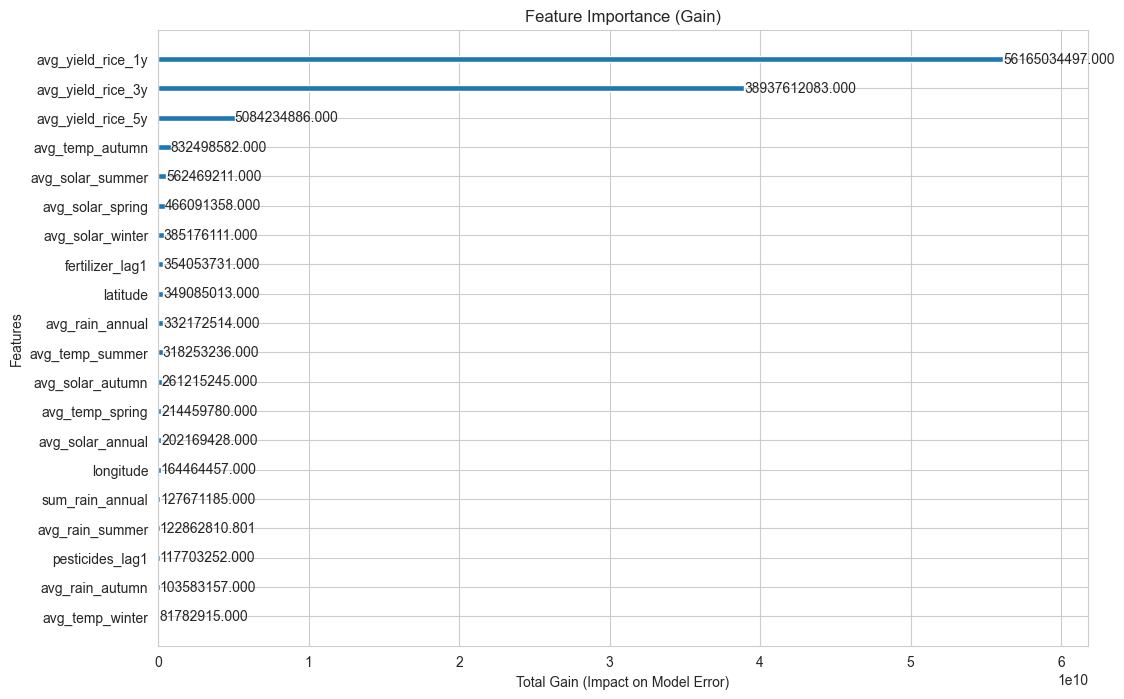

In [34]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances (using 'gain' for accuracy contribution)
importances = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.feature_name_

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Gain)': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance (Gain)', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use LightGBM's built-in plotter
lgb.plot_importance(
    final_model, 
    max_num_features=20, 
    importance_type='gain', 
    figsize=(12, 8), 
    title='Feature Importance (Gain)',
    xlabel='Total Gain (Impact on Model Error)'
)
plt.show()